reproduction of the paper

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# takes 3 seconds to run, gotta make it faster

def eos_therm(filepath):
    """Output arrays in order: epsilon, pressure, number density."""
    with open(f'{filepath}/eos.thermo', 'r') as f:
        first_line = f.readline().strip()

    m_n, m_p, i_l = map(float, first_line.split())

    data = np.loadtxt(f'{filepath}/eos.thermo', skiprows=1) # skip first line which is loaded in the line above

    nb_values = np.loadtxt(f'{filepath}/eos.nb', skiprows=2) # first two rows contains max and min values
    T_values = np.loadtxt(f'{filepath}/eos.t', skiprows=2)
    Y_values = np.loadtxt(f'{filepath}/eos.yq', skiprows=2)

    # Initialize an empty list to store the p values
    p_values = []
    e_values = []

    # Get the reference values for comparison
    ref_i_T = data[0][0]
    ref_i_y = data[0][2]

    # Iterate through the data array
    for row in data:
        i_T, i_nb, i_y, p_over_nb, e_over_stuff = row[0]-1, row[1]-1, row[2]-1, row[3], row[11]
        
        # Check if the current row matches the reference values
        if i_T == ref_i_T and i_y == ref_i_y:
            nb = nb_values[int(i_nb)]
            p = p_over_nb * nb
            p_values.append(p)
            e = (e_over_stuff+1) * nb * m_n
            e_values.append(e)
    
    return np.array(p_values), np.array(e_values), np.array(nb_values)

In [3]:
eos1 = 'EOS/eoses/eos1'

p_eos1, e_eos1, n_eos1 = eos_therm(eos1)

$$n = \frac{\epsilon+p}{\mu}$$
$$\mu=\frac{\epsilon+p}{n}$$

In [4]:
mu_eos1 = (e_eos1+p_eos1)/n_eos1

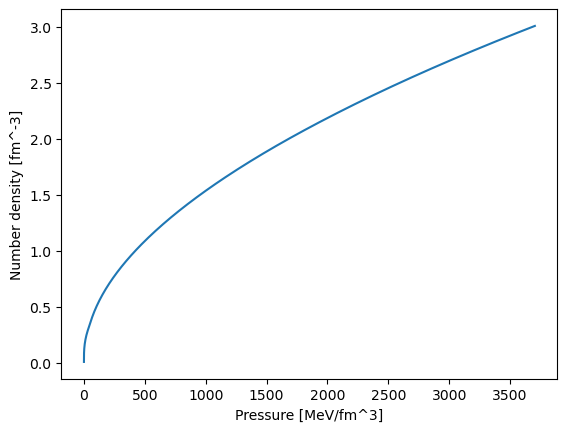

In [5]:
plt.plot(p_eos1, n_eos1)
plt.xlabel('Pressure [MeV/fm^3]')
plt.ylabel('Number density [fm^-3]')
plt.show()

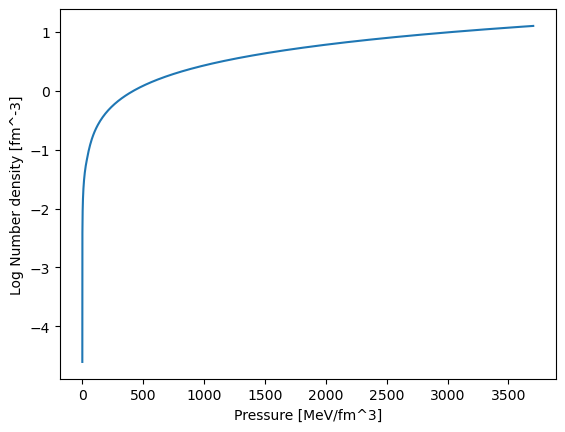

In [6]:
plt.plot(p_eos1, np.log(n_eos1))
plt.xlabel('Pressure [MeV/fm^3]')
plt.ylabel('Log Number density [fm^-3]')
plt.show()

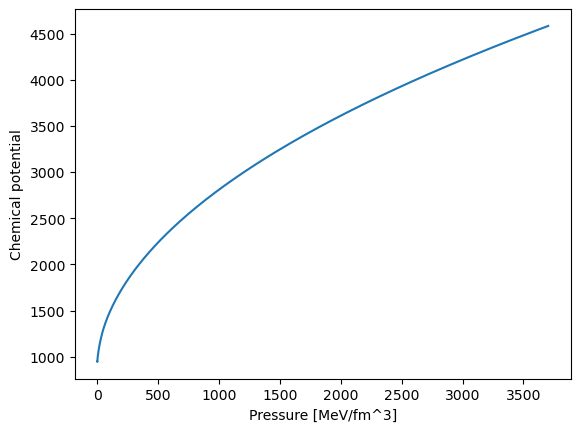

In [7]:
plt.plot(p_eos1, mu_eos1)
plt.xlabel('Pressure [MeV/fm^3]')
plt.ylabel('Chemical potential')
plt.show()

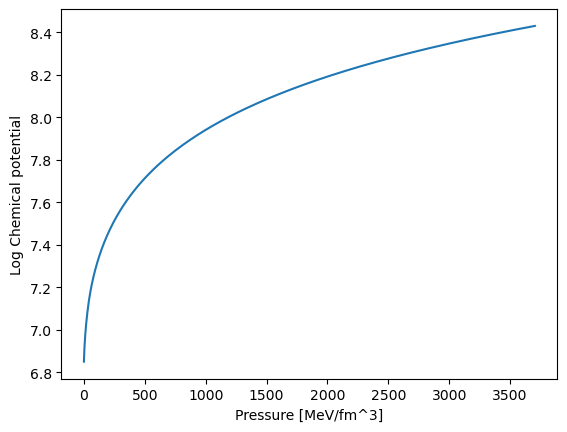

In [8]:
plt.plot(p_eos1, np.log(mu_eos1))
plt.xlabel('Pressure [MeV/fm^3]')
plt.ylabel('Log Chemical potential')
plt.show()

In [9]:
def get_chemical_potential(epsilon, pressure, c=1, mu_0=939.5):

    """Returns array filled with ln [mu(epsilon)]
    Assumes mu_0 is m_n for now"""

    from scipy.integrate import cumulative_trapezoid as cumtrapz
    epsi_0 = epsilon[0]  
    p_0 = pressure[0]

    # compute the integrand
    integrand = epsilon * c**2 / (epsilon + pressure)

    # numerically integrate using cumulative trapezoidal rule
    integral = cumtrapz(integrand, epsilon, initial=0)  # Integral array

    # log of chemical potential at each epsilon
    log_mu = integral + np.log(mu_0)

    return log_mu

def get_number_density(epsilon,pressure,log_mu):
    
    """From energy, pressure and chemical potential get the number density"""

    ln_n = np.log(epsilon+pressure) - log_mu

    return ln_n

from the other nb, these fx's don't return same mu, logging the result again gets back something similar

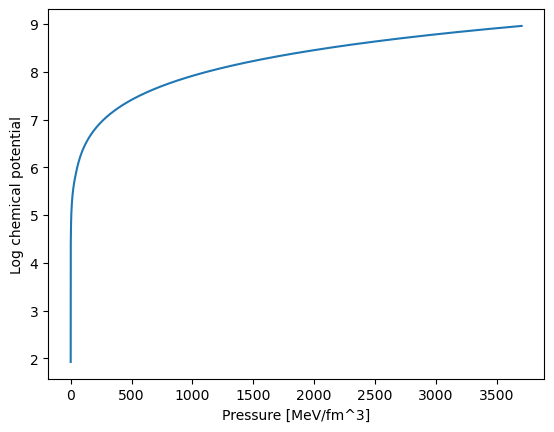

In [10]:
log_mu_eos1 = get_chemical_potential(e_eos1, p_eos1)

ln_n_eos1 = get_number_density(e_eos1, p_eos1, log_mu_eos1)

plt.plot(p_eos1, np.log(log_mu_eos1))
plt.xlabel('Pressure [MeV/fm^3]')
plt.ylabel('Log chemical potential')
plt.show()

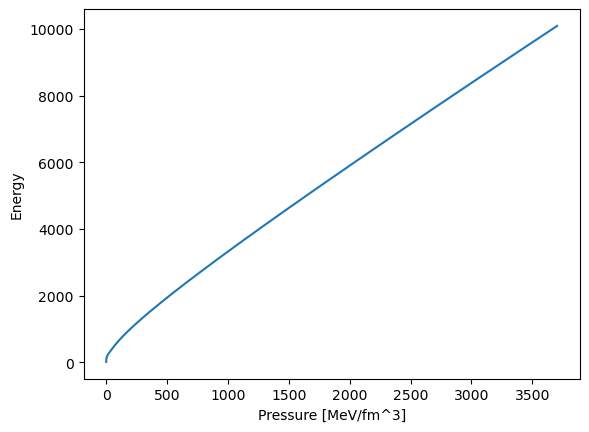

In [11]:
plt.plot(p_eos1, e_eos1)
plt.xlabel('Pressure [MeV/fm^3]')
plt.ylabel('Energy') # dimensions? consult manual
plt.show()

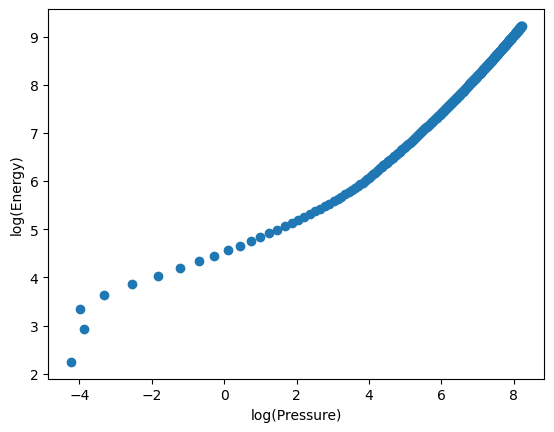

In [12]:
logp1= np.log(p_eos1)
loge1= np.log(e_eos1)

plt.scatter(logp1, loge1)
plt.xlabel('log(Pressure)')
plt.ylabel('log(Energy)')
plt.show()

### Residuals

In [13]:
from numpy.polynomial.polynomial import polyfit, polyval

In [14]:
coeffs = polyfit(logp1, loge1, 3) # 3rd degree because of fig 1, see if change to this changes the final gpr

loge1_fit = polyval(logp1, coeffs)

residuals_e_1 = loge1 - loge1_fit

### Indiv EOS GPR

In [15]:
from scipy.linalg import cholesky, solve_triangular

import dickandballs as db

def myfit(x1, x2, f, kernel):

    kernel = kernel
    K_11 = kernel.compute(x1)
    K_12 = kernel.compute(x1, x2)
    K_22 = kernel.compute(x2)

    L = cholesky(K_11, lower=True)
    y = solve_triangular(L, f, lower=True)
    alpha = solve_triangular(L.T, y, lower=False)
    mean_star = K_12.T @ alpha

    v = solve_triangular(L, K_12, lower=True)
    cov_star = K_22 - (v.T @ v)

    bruh = v.T@v

    return mean_star, cov_star

In [16]:
logp1.shape

(301,)

In [21]:
print(np.linalg.eigvals(my_kernel.compute(logp1, logp1)))

[ 3.01000000e+02+0.00000000e+00j -1.55814802e-14+7.39941939e-15j
 -1.55814802e-14-7.39941939e-15j  1.37848345e-14+7.77319474e-15j
  1.37848345e-14-7.77319474e-15j -2.19262603e-17+1.35689713e-14j
 -2.19262603e-17-1.35689713e-14j -1.35177234e-14+0.00000000e+00j
 -5.61049534e-16+1.08620419e-14j -5.61049534e-16-1.08620419e-14j
  4.60731690e-15+9.50737811e-15j  4.60731690e-15-9.50737811e-15j
  9.41474686e-15+2.91926749e-15j  9.41474686e-15-2.91926749e-15j
 -3.91057254e-15+9.05372559e-15j -3.91057254e-15-9.05372559e-15j
 -9.19646541e-15+2.10813241e-15j -9.19646541e-15-2.10813241e-15j
  6.36935823e-15+6.19879479e-15j  6.36935823e-15-6.19879479e-15j
  3.10385845e-15+8.57084319e-15j  3.10385845e-15-8.57084319e-15j
 -6.64675620e-15+6.40113229e-15j -6.64675620e-15-6.40113229e-15j
  1.88873497e-15+8.66943530e-15j  1.88873497e-15-8.66943530e-15j
  8.48675655e-15+0.00000000e+00j -7.50287963e-15+4.71731355e-15j
 -7.50287963e-15-4.71731355e-15j -4.12525268e-15+7.68412525e-15j
 -4.12525268e-15-7.684125

In [17]:
# the squared exponential kernel is RBF kernel
my_kernel = db.Kernel('SE', sigma=1, l=1)

X_pred = np.linspace(min(logp1), max(logp1), 100).reshape(-1, 1)

mean_star, cov_star = myfit(logp1, X_pred, residuals_e_1, kernel=my_kernel)
# fit the model to the residuals
res_pred = np.random.multivariate_normal(mean_star, cov_star)
sigma = np.sqrt(np.diag(cov_star))
# add the polynomial to the GPR predictions
y_pred = res_pred + polyval(X_pred.ravel(), coeffs)

plt.figure()
plt.plot(logp1, loge1, 'r.', markersize=10, label='Observations')
plt.plot(X_pred, y_pred, '-', color='black', label='GPR prediction')
plt.fill_between(X_pred.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.2, color='k')
plt.xlabel('logp1')
plt.ylabel('loge1')
plt.legend()
plt.show()

LinAlgError: 3-th leading minor of the array is not positive definite

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

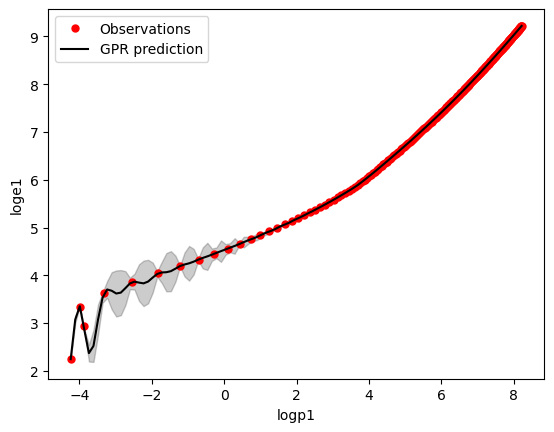

In [ ]:
# the squared exponential kernel is RBF kernel
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel=kernel)
# fit the model to the residuals
gpr.fit(logp1.reshape(-1, 1), residuals_e_1.reshape(-1, 1))

X_pred = np.linspace(min(logp1), max(logp1), 100).reshape(-1, 1)
res_pred, sigma = gpr.predict(X_pred, return_std=True)

# add the polynomial to the GPR predictions
y_pred = res_pred + polyval(X_pred.ravel(), coeffs)

plt.figure()
plt.plot(logp1, loge1, 'r.', markersize=10, label='Observations')
plt.plot(X_pred, y_pred, '-', color='black', label='GPR prediction')
plt.fill_between(X_pred.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.2, color='k')
plt.xlabel('logp1')
plt.ylabel('loge1')
plt.legend()
plt.show()

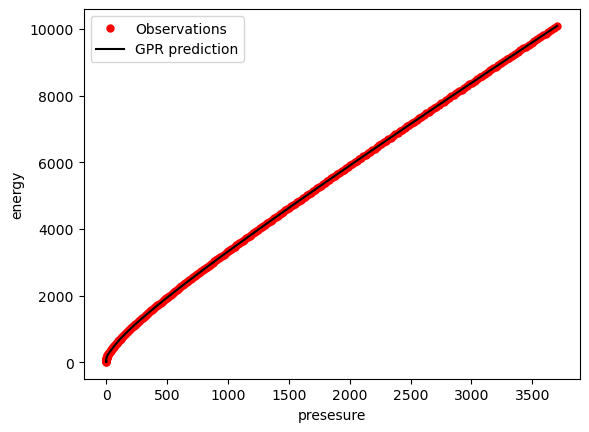

In [108]:
plt.figure()
plt.plot(np.exp(logp1), np.exp(loge1), 'r.', markersize=10, label='Observations')
plt.plot(np.exp(X_pred), np.exp(y_pred), '-', color='black' , label='GPR prediction')
plt.fill_between(np.exp(X_pred.ravel()), np.exp(y_pred - 1.96 * sigma), np.exp(y_pred + 1.96 * sigma), alpha=0.2, color='k')
plt.xlabel('presesure')
plt.ylabel('energy')
plt.legend()
plt.show()

# how np.func.outer works

In [2]:
A=[1, 2, 3, 4]
B = [5, 6, 7]

In [3]:
r = np.empty((len(A),len(B)))
for i in range(len(A)):
    for j in range(len(B)):
        r[i,j] = np.multiply(A[i], B[j])  # op = ufunc in question
        print(A[i], 'X', B[j], '=', r[i,j])

1 X 5 = 5.0
1 X 6 = 6.0
1 X 7 = 7.0
2 X 5 = 10.0
2 X 6 = 12.0
2 X 7 = 14.0
3 X 5 = 15.0
3 X 6 = 18.0
3 X 7 = 21.0
4 X 5 = 20.0
4 X 6 = 24.0
4 X 7 = 28.0


In [4]:
r

array([[ 5.,  6.,  7.],
       [10., 12., 14.],
       [15., 18., 21.],
       [20., 24., 28.]])

In [8]:
np.multiply(A,B)

array([ 4, 10, 18])